# Deep Learning in Finance

Deep Learning, a start of the art methodology used to deal with huge amount of data and can handle both supervised and unsupervised data. 
The amazing part of this Deep Learning is that it uses Neural Netwroks - an interconnected web of nodes and the edges that join them together. It has a potential to learn the features and reduce errors through Forward propogation and Backward propogation. The errors are minimised through Gradient Descent techniques. 

### Applications of Deep Learning

Sentiment Analysis <br>
Named Entity Recognition <br>
Image Recognition <br>
Object Recognition <br>
Speech Recognition <br>
Time Series Analysis and many more...<br>

### Deep Learning in Finance

Stock Market Prediction <br>
Financial Security <br>
Automation Process <br>
Analysing Trading Strategies <br>
Loan Application Evaluation <br>
Credit Card Customer Research and many more... <br>
##### Companies like CRISIL, JP Morgan Chase, BNY Mello and others are using Deep Learning Frameworks in their financial fields.<br>
Here we will be discussing about Stock Market Prediction.

### Stock Market Prediction 
Here, we try to predict the direction of market(uptrend or downtrend) using a set of features, thus we can consider it as a Binary Classification problem i.e <br>
0 => Downtrend <br>
1 => Uptrend

### 1. Getting the system ready and loading the data

In [42]:
# Importing the required packages

import pandas as pd
import numpy as np
import math 

# Using Yahoo Finance library - Installation -> pip install yfinance
import yfinance as yf 

# to preprocess the data
from sklearn.preprocessing import MinMaxScaler

# to create Visualisations
import seaborn as sns
import matplotlib.pyplot as plt 

# to create a LSTM model
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.layers import LSTM

# to calculate the metrics
from sklearn.metrics import confusion_matrix, mean_squared_error

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Loading the data 
# Using Apple's stock price data from 1st Jan, 2018 to 26th July, 2020
dataset = yf.download("AAPL", start="2018-01-01", end="2020-07-26")

[*********************100%***********************]  1 of 1 completed


### 2. Dataset Content

In [3]:
dataset.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-01-02,170.160004,172.300003,169.259995,172.259995,166.353714,25555900
2018-01-03,172.529999,174.550003,171.960007,172.229996,166.324722,29517900
2018-01-04,172.539993,173.470001,172.080002,173.029999,167.097290,22434600
2018-01-05,173.440002,175.369995,173.050003,175.000000,168.999741,23660000
2018-01-08,174.350006,175.610001,173.929993,174.350006,168.372040,20567800


In [4]:
dataset.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-07-20,385.670013,394.000000,384.250000,393.429993,393.429993,22579500
2020-07-21,396.690002,397.000000,386.970001,388.000000,388.000000,25911500
2020-07-22,386.769989,391.899994,386.410004,389.089996,389.089996,22250400
2020-07-23,387.989990,388.309998,368.040009,371.380005,371.380005,49251100
2020-07-24,363.950012,371.880005,356.579987,370.459991,370.459991,46359700


In [5]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 645 entries, 2018-01-02 to 2020-07-24
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       645 non-null    float64
 1   High       645 non-null    float64
 2   Low        645 non-null    float64
 3   Close      645 non-null    float64
 4   Adj Close  645 non-null    float64
 5   Volume     645 non-null    int64  
dtypes: float64(5), int64(1)
memory usage: 35.3 KB


We can see that the last entry is on 24th July, 2020. 
The stock markets are closed on Saturdays' and Sundays' along with some public holidays.
25th and 26th of July are Saturday and Sunday respectively.

In [6]:
# Understanding the features/columns in the dataset
dataset.columns

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')

Open &emsp;   - Opening value of stock price <br>
High &emsp;  - Highest value of the stock price in that day <br>
Low  &emsp;   - Lowest value of the stock price in that day <br>
Close &emsp;  - Closing value of the stock price in that day <br>
Adj Close - Adjusted Closing values of the stock price after closing. <br>
&emsp; &emsp; &emsp; &emsp; &ensp; Generally the stock value after the dividends or stock-splits or stock offerings are posted.<br>
Volume  - Total number of shares traded in that day.

Adjusted closing price amends a stock's closing price to accurately reflect that stock's value after accounting for any corporate actions. <br>
The closing price is the 'raw' price which is just the cash value of the last transacted price before the market closes. <br>
Adjusted closing price factors in corporate actions such as stock splits, dividends / distributions and rights offerings.<br>Investopedia

### 3. Preprocessing the Data

Adjustment Factor = (Close - Dividend)/Close <br>
We need to multipy all the historical prices preceeding the dividend by the Adjustment Factor. 

In [7]:
# Calculating Adjustment Factor
dataset['AdjustmentFactor'] = dataset['Adj Close']/dataset['Close']

# Adjusting Open, High and Low values
dataset['Adj Open'] = dataset['Open'] * dataset['AdjustmentFactor']
dataset['Adj High'] = dataset['High'] * dataset['AdjustmentFactor']
dataset['Adj Low'] = dataset['Low'] * dataset['AdjustmentFactor']

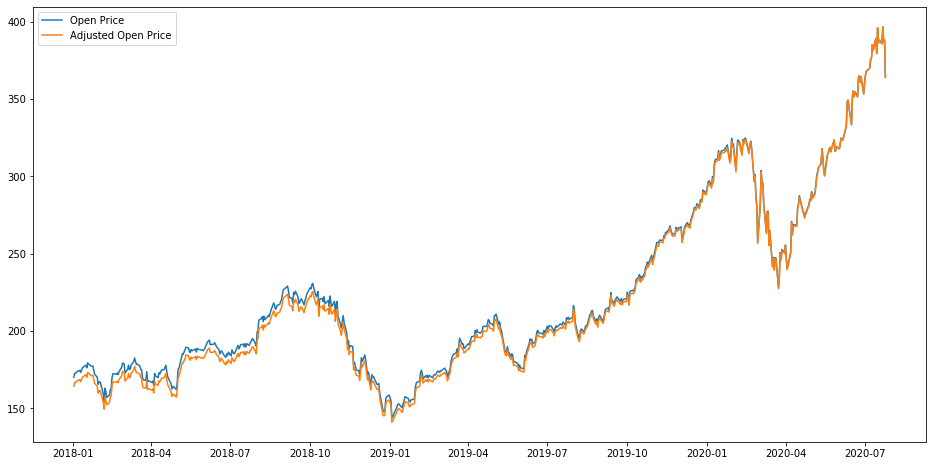

In [8]:
# Exploring the Open price and Adjusted Open Price
plt.figure(figsize=(16,8))
plt.plot(dataset.index, dataset.Open, label='Open Price')
plt.plot(dataset.index, dataset['Adj Open'], label='Adjusted Open Price')
plt.legend()
plt.show()

### 4. Feature Extraction

We will be using the following features for classification <br>
1. Mean value of Adjusted Open, High and Low. <br>
2. Adjusted Close value. <br>
3. Returns of the day before.

In [9]:
# 1. Mean of Adjusted Open, High and Low
OHL_mean = dataset[['Adj Open','Adj High','Adj Low']].mean(axis = 1)

In [10]:
# 2. Adjusted Close
close_value = dataset[["Adj Close"]]

In [11]:
# 3. Returns of the day before
# Calculated using the Percentag Change
# [(Present value - Previous value)/Present Value] * 100
returns = dataset[['Adj Close']].pct_change()

In [12]:
# concatenating the above extracted features
x = pd.concat([OHL_mean, close_value, returns], axis=1)
x.columns = ['OHL', 'Adj Close', 'Returns']

In [13]:
x.head()

,OHL,Adj Close,Returns
Date,,,
2018-01-02,164.724884,166.353714,NaN
2018-01-03,167.081204,166.324722,-0.000174
2018-01-04,166.775386,167.097290,0.004645
2018-01-05,167.988961,168.999741,0.011385
2018-01-08,168.642433,168.372040,-0.003714


In [14]:
# Converting x dataframe into a numpy array for easier data manipulation
x = x.to_numpy()

In [15]:
# Calculating the target variable
# -1 if Returns <0
# 0 if Returns = 0
# 1 if Returns >= 1
# Since binary classification consists of 0s and 1s as target variables...
# We are adding 1 to convert negative 1s to 0s.
y = (np.sign(x[:,2])+1)/2

### 5. Feature Scaling

In [16]:
# If you observe the data values are not normally scaled...this cause
# bias when the model is training.

# # Defining the min-max scalar for scaling the features
scaler = MinMaxScaler(feature_range=(0, 1))

# Scaling the features
x = scaler.fit_transform(x)

In [17]:
# Concatenating the features and target variables
xy = np.concatenate([x, y.reshape(-1, 1)], axis=1)

In [18]:
# Shape of the data
xy.shape

(645, 4)

In [19]:
# Remove all rows with either feature or label null
xy = xy[~np.isnan(xy).any(axis=1)]

xy.shape

(644, 4)

In [20]:
# Splitting the data into train and test data
train_xy_len = int(xy.shape[0]*0.75) # 75% of the data is used to train
train_xy, test_xy = xy[0:train_xy_len], xy[train_xy_len:]

train_x = train_xy[:,:3]
train_y = train_xy[:,3]
test_x = test_xy[:,:3]
test_y = test_xy[:,3]

In [21]:
# Reshaping the data so as to fit in the model
train_x = np.reshape(train_x, (train_x.shape[0], 1, train_x.shape[1]))
test_x = np.reshape(test_x, (test_x.shape[0], 1, test_x.shape[1]))

### 6. Creating the model

In [22]:
# Number of features
step_size = 3
 
#Define the sequential object
classifier = Sequential()

# Add LSTM later with 50 units and input size (1,3)
classifier.add(LSTM(units = 50, return_sequences = True, input_shape = (1, step_size)))

# Add dropout for regularisation 
classifier.add(Dropout(0.2))

# Add another LSTM unit
classifier.add(LSTM(units = 50, return_sequences = True))

# Add dropout for regularisation 
classifier.add(Dropout(0.2))
classifier.add(LSTM(units = 50, return_sequences = True))
classifier.add(Dropout(0.2))
classifier.add(LSTM(units = 50))
classifier.add(Dropout(0.2))

# Add fully connected layer with one output
classifier.add(Dense(units = 1))
 
# Compile the model - set loss function, optimisation algorithm and evaluation metric
classifier.compile(loss='mean_squared_error', optimizer='adam',metrics=['accuracy'])

In [23]:
# Train the model 
history = classifier.fit(train_x, train_y, epochs=25, batch_size=1,  validation_split=0.33)
 
# Get test and train set predictions
trainPredict = classifier.predict(train_x)
testPredict = classifier.predict(test_x)

Train on 323 samples, validate on 160 samples
Epoch 1/25
323/323 [==============================] - 11s 35ms/step - loss: 0.3001 - accuracy: 0.5077 - val_loss: 0.2470 - val_accuracy: 0.5188
Epoch 2/25
323/323 [==============================] - 4s 13ms/step - loss: 0.2436 - accuracy: 0.5511 - val_loss: 0.2427 - val_accuracy: 0.5188
Epoch 3/25
323/323 [==============================] - 4s 12ms/step - loss: 0.2270 - accuracy: 0.6254 - val_loss: 0.2208 - val_accuracy: 0.7125
Epoch 4/25
323/323 [==============================] - 4s 12ms/step - loss: 0.2209 - accuracy: 0.6223 - val_loss: 0.1993 - val_accuracy: 0.6187
Epoch 5/25
323/323 [==============================] - 4s 12ms/step - loss: 0.2075 - accuracy: 0.6718 - val_loss: 0.1669 - val_accuracy: 0.8375
Epoch 6/25
323/323 [==============================] - 4s 12ms/step - loss: 0.1712 - accuracy: 0.7523 - val_loss: 0.1357 - val_accuracy: 0.9563
Epoch 7/25
323/323 [==============================] - 4s 13ms/step - loss: 0.1651 - accuracy: 0

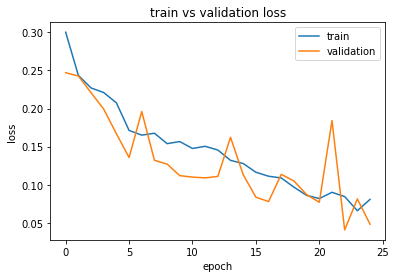

In [24]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

The spikes in validation loss can be of many reasons...one of them might the irregular data present in that batch

### 7. Metrics

In [43]:
# Since we need a binary value either 0 or 1 we will convert the obtained continuous values from prediction
# 1 if predicted value >= 0.5
# 0 if predicted value < 0.5
test = np.where(testPredict>0.5, 1, 0) 

# Get the confusion matrix for binary classification

# Reshaping the predicted values
test = test.reshape(161,)
# Converting the datatype of target values to integer value
test_y.astype(int)

cf_matrix = confusion_matrix(test_y.astype(int),test)


cf_matrix

array([[53, 17],
       [ 0, 91]])

In [ ]:
sns.heatmap(cf_matrix,
                cmap='YlGnBu')